1. Importovanje i učitavanje
Uvodim standardne biblioteke i učitavam CSV u df da bih radio analizu

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

df = pd.read_csv("data/StudentsPerformance.csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


2. Struktura + ciljevi/ulazi
Prikazujem oblik i tipove kolona, razdvajam ulaze (kategorije) od ciljeva (math/reading/writing score)

In [48]:
print("Rows, Cols:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nColumns:", list(df.columns))

targets = ["math score", "reading score", "writing score"]
features = [c for c in df.columns if c not in targets]
print("\nTargets:", targets)
print("Features:", features)

Rows, Cols: (1000, 8)

Dtypes:
 gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object

Columns: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']

Targets: ['math score', 'reading score', 'writing score']
Features: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']


3. Nedostajuće vrednosti
Proveravam da li ima NaN vrednosti

In [49]:
print(df.isna().sum())

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


4. Deskriptivna statistika
Sažetak brojeva (srednja vrednost, rasipanje, minimum/kvartili/maksimum)

In [50]:
display(df[targets].describe().T[['mean','std','min','25%','50%','75%','max']])


,mean,std,min,25%,50%,75%,max
math score,66.089,15.163080,0.0,57.00,66.0,77.0,100.0
reading score,69.169,14.600192,17.0,59.00,70.0,79.0,100.0
writing score,68.054,15.195657,10.0,57.75,69.0,79.0,100.0


5. Kategorije - jedinstvene vrednosti
Pregledam koje diskretne grupe postoje i koliko su raznovrsne

In [51]:
cat_cols = df.drop(columns=targets).select_dtypes(include='object').columns.tolist()
for c in cat_cols:
    print(f"{c}: {df[c].nunique()} unique -> {sorted(df[c].unique())}")

gender: 2 unique -> ['female', 'male']
race/ethnicity: 5 unique -> ['group A', 'group B', 'group C', 'group D', 'group E']
parental level of education: 6 unique -> ["associate's degree", "bachelor's degree", 'high school', "master's degree", 'some college', 'some high school']
lunch: 2 unique -> ['free/reduced', 'standard']
test preparation course: 2 unique -> ['completed', 'none']


6. Uredjivanje kategorije sa prirodnim poretkom

In [52]:
edu_order = [
    "some high school","high school","some college","associate's degree","bachelor's degree","master's degree"
]
df["parental level of education"] = pd.Categorical(
    df["parental level of education"], categories=edu_order, ordered=True
)

7. Prikaz veličine grupa po kategorijama


Number of students by: lunch
           lunch  count
0      standard    645
1  free/reduced    355


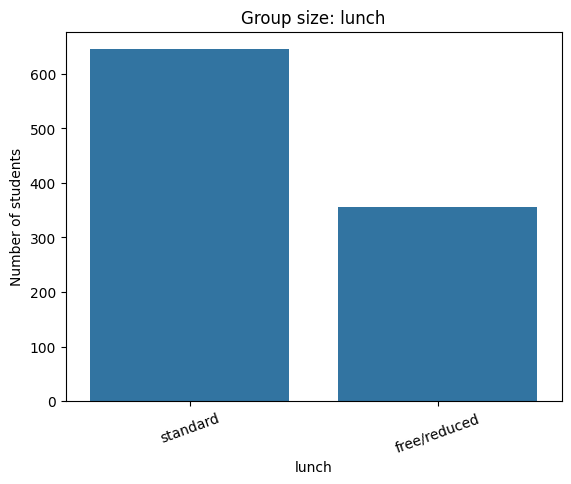


Number of students by: test preparation course
   test preparation course  count
0                    none    642
1               completed    358


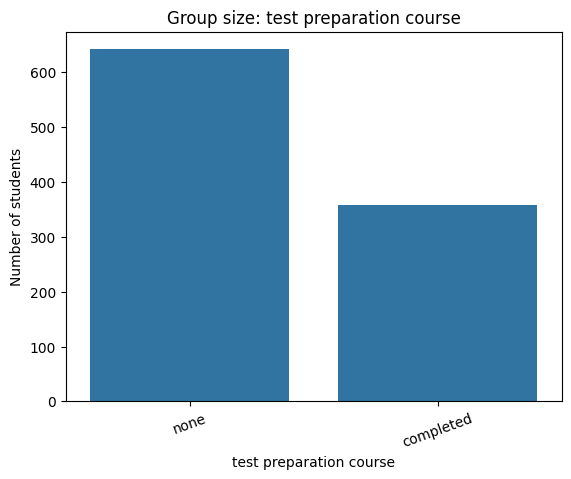


Number of students by: parental level of education
   parental level of education  count
0                some college    226
1          associate's degree    222
2                 high school    196
3            some high school    179
4           bachelor's degree    118
5             master's degree     59


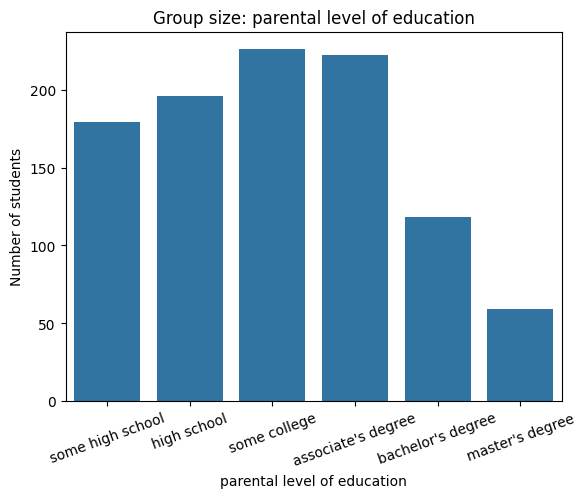


Number of students by: gender
    gender  count
0  female    518
1    male    482


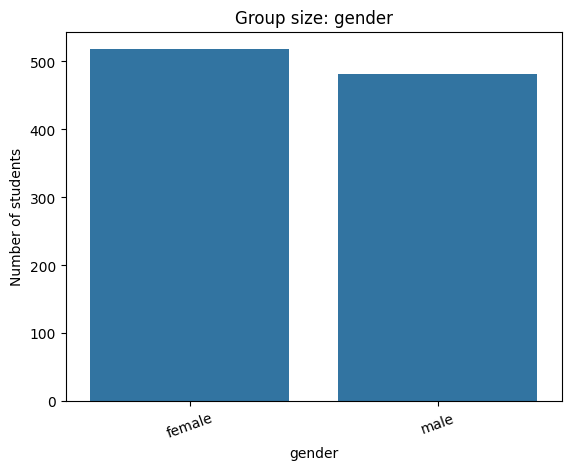


Number of students by: race/ethnicity
   race/ethnicity  count
0        group C    319
1        group D    262
2        group B    190
3        group E    140
4        group A     89


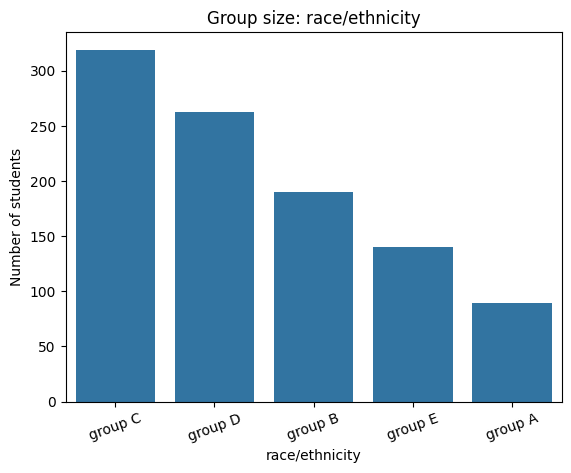

In [53]:
for c in ["lunch","test preparation course","parental level of education","gender","race/ethnicity"]:
    counts = df[c].value_counts().reset_index()
    counts.columns = [c, "count"]
    print(f"\nNumber of students by: {c}\n", counts)
    plt.figure()
    sns.barplot(data=counts, x=c, y="count")
    plt.title(f"Group size: {c}")
    plt.xlabel(c); plt.ylabel("Number of students")
    plt.xticks(rotation=20)
    plt.show()

8. Histogrami ciljeva
Vidi se raspodela svake ocene

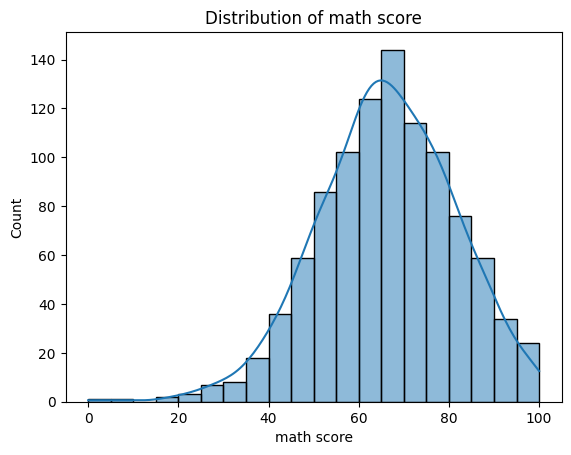

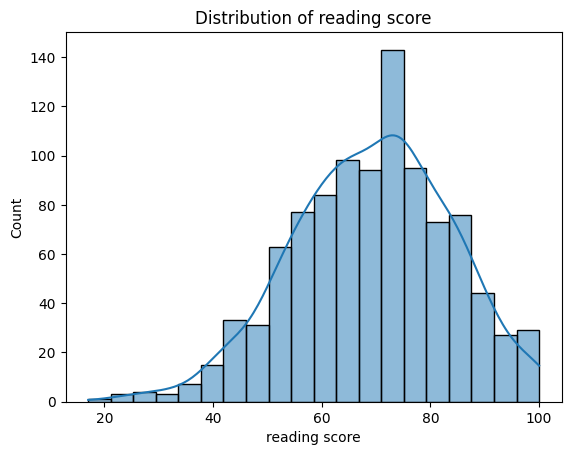

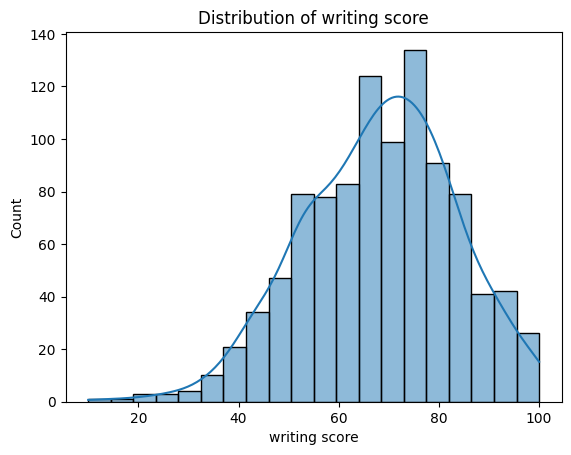

In [54]:
for t in targets:
    plt.figure()
    sns.histplot(df[t], bins=20, kde=True)
    plt.title(f"Distribution of {t}")
    plt.xlabel(t); plt.ylabel("Count")
    plt.show()

9. Boxplot ciljeva
Poređenje medijane, raspona srednjih 50% i moguće autlajere za tri ocene na jednom grafiku

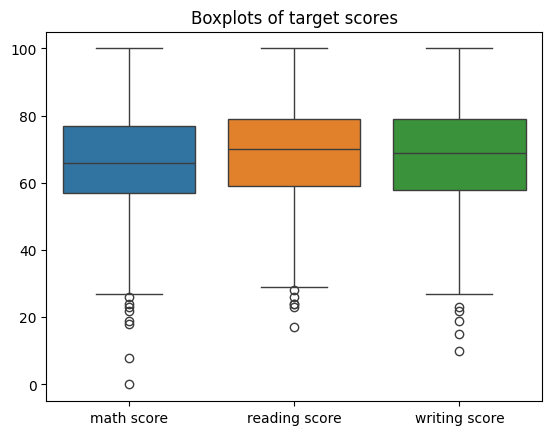

In [55]:
plt.figure()
sns.boxplot(data=df[targets])
plt.title("Boxplots of target scores")
plt.show()

10. Korelacije između ciljeva
Matrica korelacije pokazuje koliko su math/reading/writing međusobno povezani

               math score  reading score  writing score
math score       1.000000       0.817580       0.802642
reading score    0.817580       1.000000       0.954598
writing score    0.802642       0.954598       1.000000


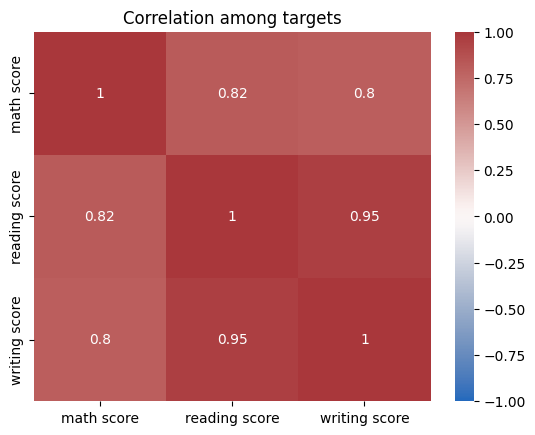

In [56]:
corr = df[targets].corr()
print(corr)
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap="vlag")
plt.title("Correlation among targets")
plt.show()

Rezultat ove analize predstavlja blisku povezanost reading i writing rezultata iz razloga što su te veštine usko povezane, pa se međusobno dopunjuju pri čemu rezultati moraju biti slični.

11. Srednje vrednosti po kategorijama
Grupisanje po kategorijama otkrivaju koje grupe imaju više ili niže proseke

In [57]:
effect_tables = {}
for c in cat_cols:
    means = df.groupby(c, observed=True)[targets].mean()
    means = means.sort_values(by="math score", ascending=False)
    effect_tables[c] = means
    print(f"\nAverage scores by {c}:\n", effect_tables[c])



Average scores by gender:
         math score  reading score  writing score
gender                                          
male     68.728216      65.473029      63.311203
female   63.633205      72.608108      72.467181

Average scores by race/ethnicity:
                 math score  reading score  writing score
race/ethnicity                                          
group E          73.821429      73.028571      71.407143
group D          67.362595      70.030534      70.145038
group C          64.463950      69.103448      67.827586
group B          63.452632      67.352632      65.600000
group A          61.629213      64.674157      62.674157

Average scores by parental level of education:
                              math score  reading score  writing score
parental level of education                                          
master's degree               69.745763      75.372881      75.677966
bachelor's degree             69.389831      73.000000      73.381356
associate's 

12. Prikaz rezultata u zavisnosti od ručka i pripreme za test


Average for math score (Lunch × Test-prep):
 test preparation course  completed   none
lunch                                    
free/reduced                 63.05  56.51
standard                     73.53  68.13


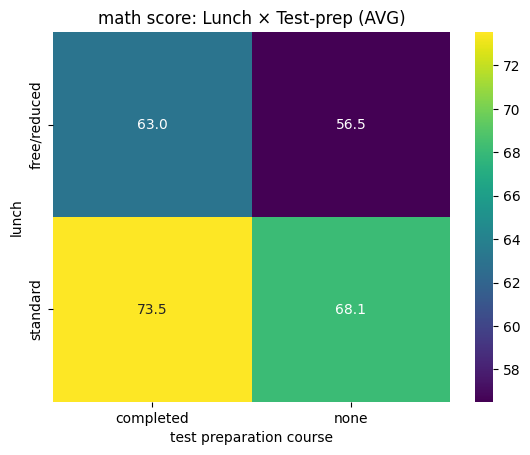


Average for reading score (Lunch × Test-prep):
 test preparation course  completed   none
lunch                                    
free/reduced                 69.87  61.60
standard                     76.22  69.18


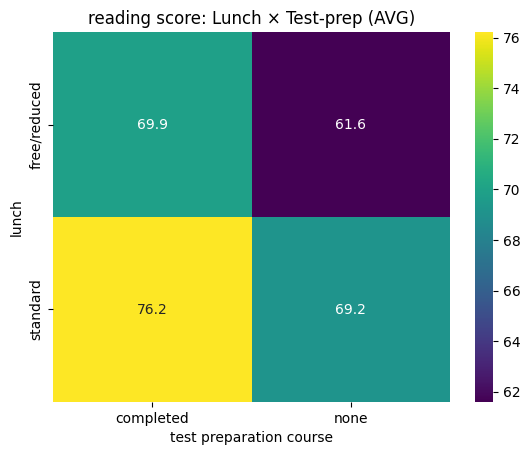


Average for writing score (Lunch × Test-prep):
 test preparation course  completed   none
lunch                                    
free/reduced                 70.35  58.74
standard                     76.77  67.60


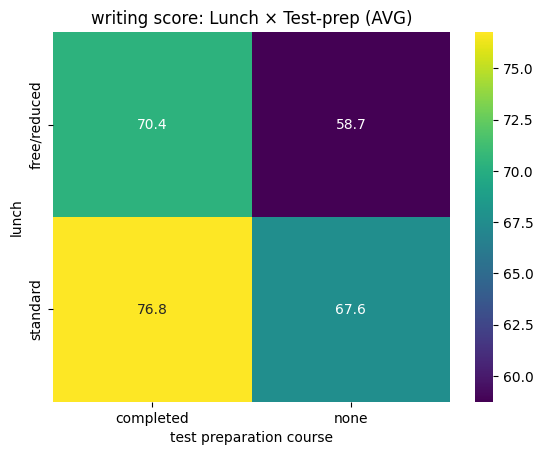

In [58]:
import seaborn as sns, matplotlib.pyplot as plt
for y in targets:
    pv = pd.pivot_table(
        df, values=y, index="lunch", columns="test preparation course", aggfunc="mean"
    )
    print(f"\nAverage for {y} (Lunch × Test-prep):\n", pv.round(2))
    sns.heatmap(pv, annot=True, fmt=".1f", cmap="viridis")
    plt.title(f"{y}: Lunch × Test-prep (AVG)")
    plt.ylabel("lunch"); plt.xlabel("test preparation course")
    plt.show()


Rezultati pokazuju da učenici koji imaju besplatan (subvencionisan) ručak imaju u proseku lošije rezultate od učenika koji mogu sebi priuštiti standardan ručak. Ali ručak ima veći uticaj na rezultate iz matematike nego iz ostalih predmeta. Priprema za testove takođe dosta utiče na rezultate, ali ako studenti imaju standardan ručak, priprema mnogo više utiče na rezultate iz čitanja i pisanja nego iz matematike.

13. Nivo obrazovanja roditelja u poređenju sa pripremama za test

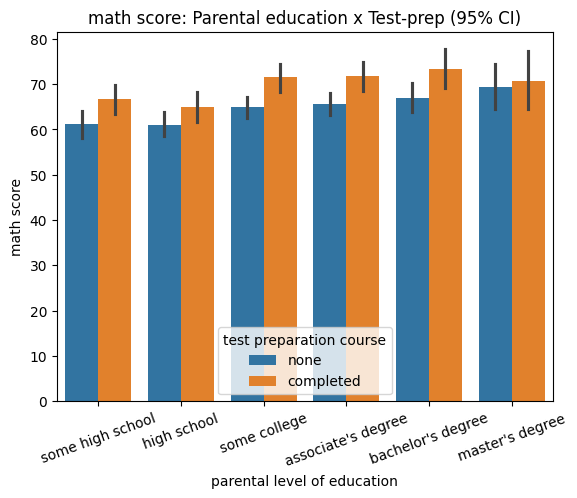

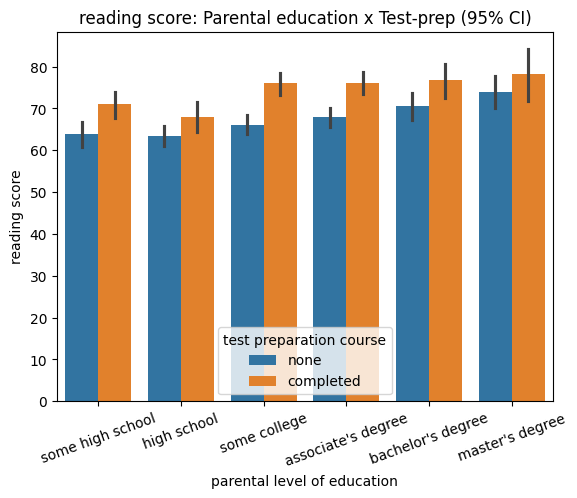

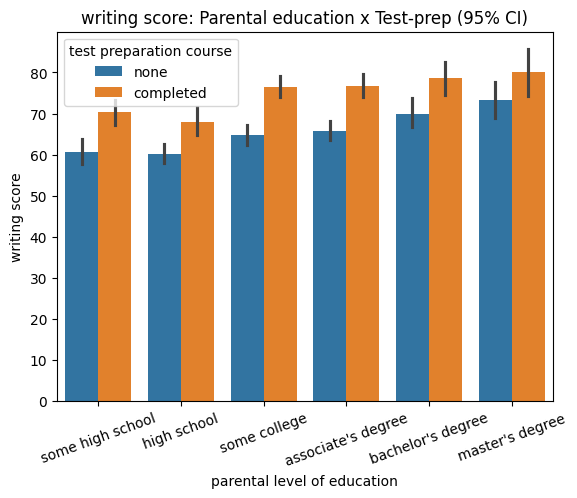

In [59]:
for y in targets:
    sns.barplot(
        data=df, x="parental level of education", y=y,
        hue="test preparation course", errorbar=("ci",95)
    )
    plt.xticks(rotation=20)
    plt.title(f"{y}: Parental education x Test-prep (95% CI)")
    plt.ylabel(y); plt.xlabel("parental level of education")
    plt.show()


Proseci rastu sa nivoom obrazovanja roditelja. Takođe se može videti da su rezultati u proseku veći kod učenika koji su završili pripreme za test u odnosu na učenike koji nisu uradili bilo kakvu pripremu.

14. Race/Ethnicity x Parental education


math score: Race/Ethnicity × Parental education
 parental level of education  some high school  high school  some college  \
race/ethnicity                                                             
group A                                 58.92        60.44         63.89   
group B                                 61.82        59.79         63.19   
group C                                 60.55        60.91         65.13   
group D                                 66.76        62.86         68.73   
group E                                 72.11        70.77         73.83   

parental level of education  associate's degree  bachelor's degree  \
race/ethnicity                                                       
group A                                   61.00              67.17   
group B                                   66.10              69.30   
group C                                   66.73              68.15   
group D                                   67.60              67.57 

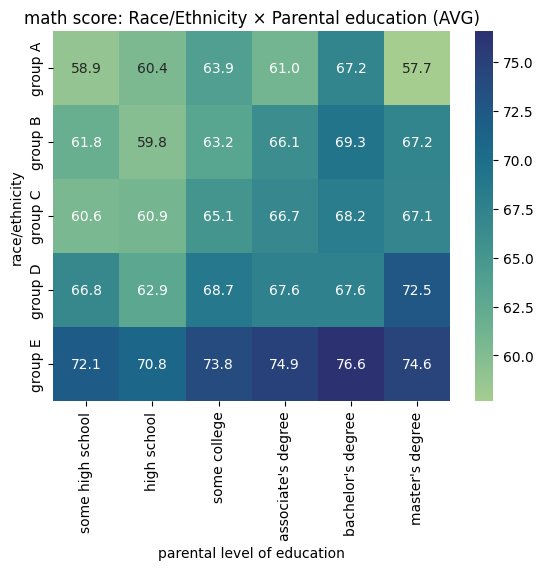


reading score: Race/Ethnicity × Parental education
 parental level of education  some high school  high school  some college  \
race/ethnicity                                                             
group A                                 62.08        62.89         65.78   
group B                                 66.45        63.46         65.76   
group C                                 65.63        64.42         69.42   
group D                                 69.98        64.41         70.88   
group E                                 69.56        70.32         72.63   

parental level of education  associate's degree  bachelor's degree  \
race/ethnicity                                                       
group A                                   67.07              68.08   
group B                                   69.59              72.95   
group C                                   71.13              75.68   
group D                                   70.54              70.

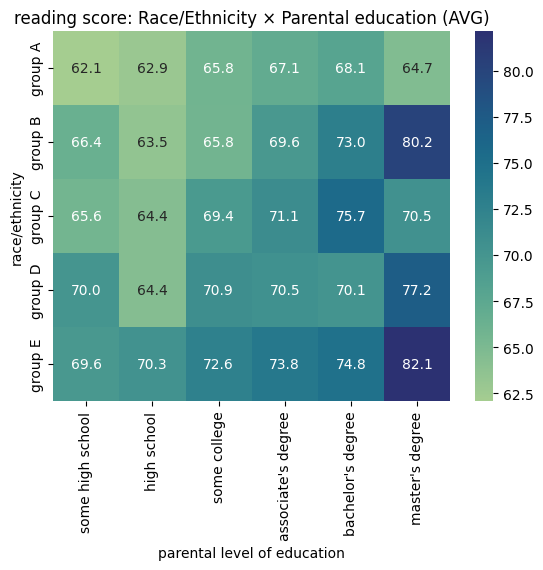


writing score: Race/Ethnicity × Parental education
 parental level of education  some high school  high school  some college  \
race/ethnicity                                                             
group A                                 58.58        60.50         65.00   
group B                                 64.61        61.25         64.19   
group C                                 63.29        61.66         68.87   
group D                                 69.10        63.16         71.70   
group E                                 66.56        67.55         70.20   

parental level of education  associate's degree  bachelor's degree  \
race/ethnicity                                                       
group A                                   63.57              68.33   
group B                                   68.24              71.65   
group C                                   70.27              75.90   
group D                                   69.86              71.

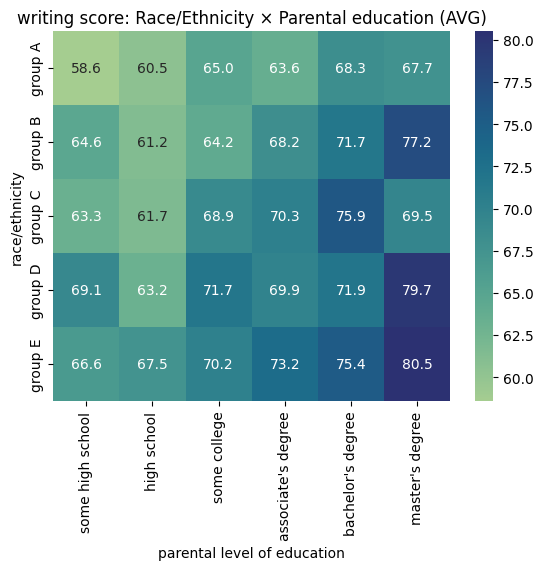

In [60]:
for y in targets:
    pv = pd.pivot_table(
        df, values=y,
        index="race/ethnicity", columns="parental level of education",
        aggfunc="mean",
        observed=False
    )
    print(f"\n{y}: Race/Ethnicity × Parental education\n", pv.round(2))
    sns.heatmap(pv, annot=True, fmt=".1f", cmap="crest")
    plt.title(f"{y}: Race/Ethnicity × Parental education (AVG)")
    plt.xlabel("parental level of education"); plt.ylabel("race/ethnicity")
    plt.show()


Analiza pokazuje da učenici koji pripadaju etničkoj grupi E imaju bolje rezultate od drugih etničkih grupa nezavisno od nivoa obrazovanja roditelja. Podaci takođe pokazuju da etnička grupa A dobija najmanje beneficije od povećanja nivoa obrazovanja roditelja. Razlika od najnižeg do najvišeg nivoa obrazovanja u prosečnim poenima je samo 9.1 poen.

15. Razlika proseka po kategorijama

Overall average (reference): 67.8

Difference vs overall mean (points) by: lunch
           lunch  diff_vs_overall
0  free/reduced             -5.6
1      standard              3.1


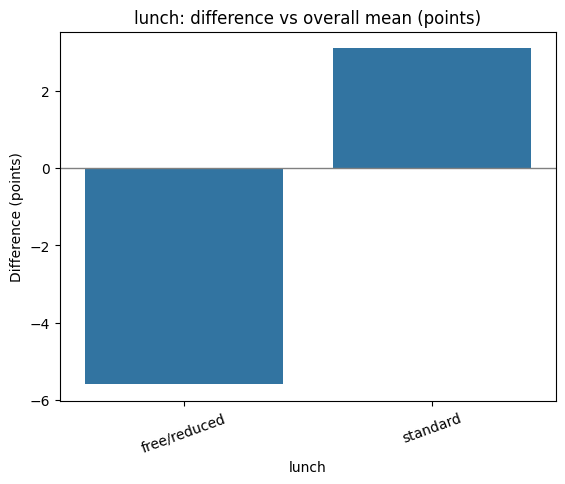


Difference vs overall mean (points) by: test preparation course
   test preparation course  diff_vs_overall
1                    none             -2.7
0               completed              4.9


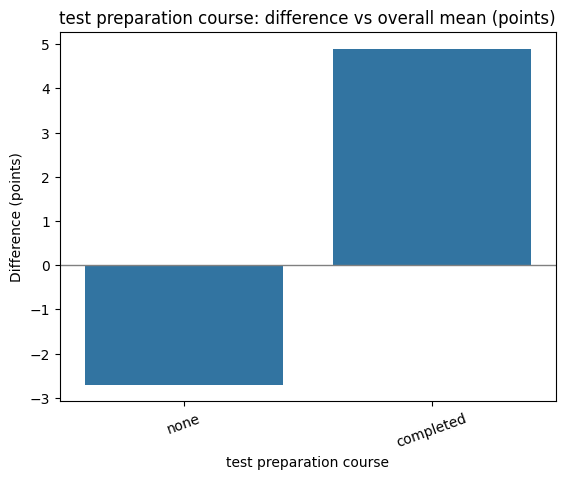


Difference vs overall mean (points) by: parental level of education
   parental level of education  diff_vs_overall
0            some high school             -2.7
1                 high school             -4.7
2                some college              0.7
3          associate's degree              1.8
4           bachelor's degree              4.2
5             master's degree              5.8


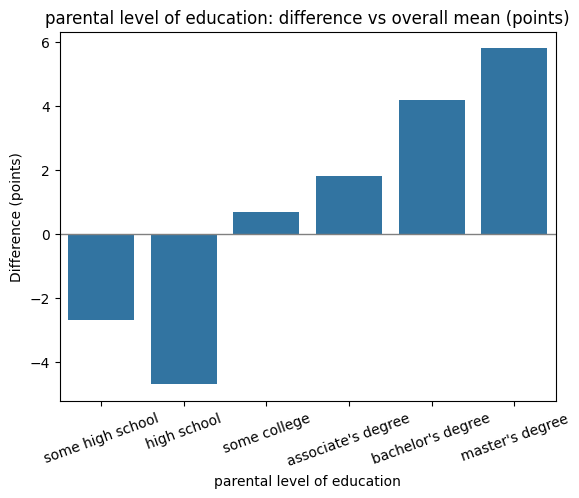


Difference vs overall mean (points) by: gender
    gender  diff_vs_overall
1    male             -1.9
0  female              1.8


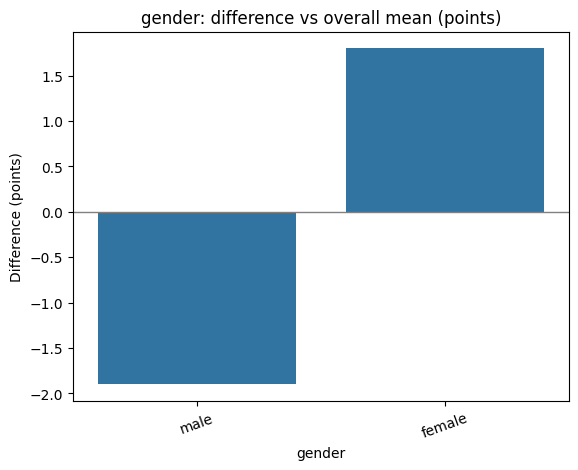


Difference vs overall mean (points) by: race/ethnicity
   race/ethnicity  diff_vs_overall
0        group A             -4.8
1        group B             -2.3
2        group C             -0.6
3        group D              1.4
4        group E              5.0


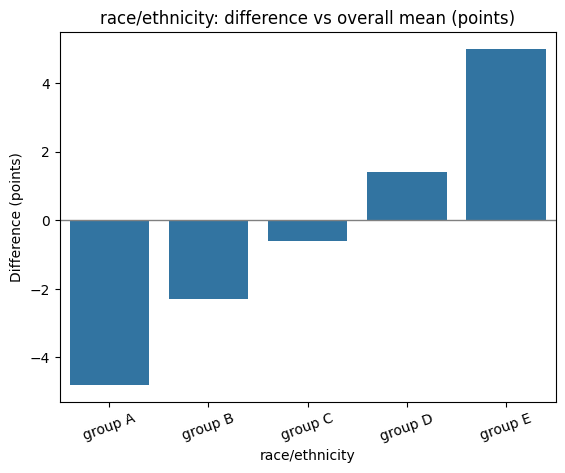

In [61]:
overall_mean = df[targets].mean().mean()
print("Overall average (reference):", round(overall_mean, 1))

categories = [
    "lunch",
    "test preparation course",
    "parental level of education",
    "gender",
    "race/ethnicity"
]

for col in categories:
    # grupni proseci po predmetima (tabela sa 3 kolone), pa srednja vrednost preko te 3 kolone
    group_means = df.groupby(col, observed=True)[targets].mean()
    means = group_means.mean(axis=1)  # jedan broj po grupi = prosečan skor

    diff_df = (means - overall_mean).round(1).rename("diff_vs_overall").reset_index()

    # poravnaj redosled za obrazovanje roditelja, ostale sortiraj po razlici
    if col == "parental level of education":
        diff_df[col] = pd.Categorical(diff_df[col], categories=edu_order, ordered=True)
        diff_df = diff_df.sort_values(col)
        order_list = edu_order
    else:
        diff_df = diff_df.sort_values("diff_vs_overall")
        order_list = diff_df[col].tolist()

    print(f"\nDifference vs overall mean (points) by: {col}\n", diff_df)

    plt.figure()
    sns.barplot(data=diff_df, x=col, y="diff_vs_overall", order=order_list, errorbar=None)
    plt.axhline(0, color="gray", linewidth=1)
    plt.title(f"{col}: difference vs overall mean (points)")
    plt.xlabel(col)
    plt.ylabel("Difference (points)")
    plt.xticks(rotation=20)
    plt.show()

Ova analiza prikazuje kolika je razlika u srednjoj vrednosti poena u odnosu na prosek. Kao što se može videti, najbolje rezultate su pokazali studenti koji pripadaju etničkoj grupi E, koji su ženskog pola, čiji roditelji imaju diplomu master studija, koji su završili pripremu za test, i koji imaju standardni ručak.